#TS-CausalNN applied to Synthetic Dataset 1


This notebook contains the proposed model. Here we have developed the proposed Causal Conv2D layer and the optimization function.

The functions to visualize the predicted causal graph are available after the model training codes. The predicted graph is compared with ground truth using an adjacency matrix (array).   

In this notebook, we applied the proposed model to the synthetic dataset-1 to generate a full causal graph and summary graph.

In [ ]:
# high SNR with inst
# Dataset V3
#Size of time-series: t
t = 100000

#Create noise
import numpy as np
import pandas as pd
import math
np.random.seed(1001)
np.set_printoptions(suppress=True)
noise = np.random.normal(0,1,t)
print(noise.size)

#Variable 1
source1 = np.zeros((t))
source1_1st_term = np.zeros((t))
source1_noise_term = noise*0.1
#source1[1] = noise[1] + 10
#source1[2] = noise[2] + 10
#for x in range(3,t):
#  source1[x] = 0.125*math.sqrt(2)*math.exp(-source1[x-1]*source1[x-1]/2) + noise[x]

for i in range(0,t):
  if(i<5):
    source1_1st_term[i] = 2 * np.cos(i/10)
    source1[i] = 2 * np.cos(i/10) + noise[i]*0.1
  else:
    source1_1st_term[i] = 2 * np.cos(i/10) + 2 * np.log(np.abs(source1[i-2] - source1[i-5]) + 1)
    source1[i] = 2 * np.cos(i/10) + 2 * np.log(np.abs(source1[i-2] - source1[i-5]) + 1) + noise[i]*0.1


#Variable 2
source2 = np.zeros((t))
source2_1st_term = np.zeros((t))
np.set_printoptions(suppress=True)
noise2 = np.random.normal(0,1,t)
noise2
import math
source2[1] = noise2[1]
source2[2] = noise2[2]
for x in range(3,t):
  if source1[x-1] > 0:
    source2_1st_term[x] = 12*math.exp(-source1[x-1]*source1[x-1]/2)  - 4*math.exp(-source1[x]*source1[x]/2)
    source2[x] = 12*math.exp(-source1[x-1]*source1[x-1]/2) + noise2[x]  - 4*math.exp(-source1[x]*source1[x]/2)
  else:
    source2_1st_term[x] = -12*math.exp(-source1[x-1]*source1[x-1])  - 4*math.exp(-source1[x]*source1[x]/2)
    source2[x] = -12*math.exp(-source1[x-1]*source1[x-1]) + noise2[x]  - 4*math.exp(-source1[x]*source1[x]/2)

#Variable 3
source3 = np.zeros((t))
source3_1st_term = np.zeros((t))
np.set_printoptions(suppress=True)
noise3 = np.random.normal(0,1,t) #np.random.normal(-0.1,0.1,t)
noise3 = noise3/5
import math
source3[1] = noise3[1]
source3[2] = noise3[2]
for x in range(3,t):
  source3_1st_term[x] = -10.5*math.exp(-source1[x-1]*source1[x-1]/2) # - 8.5 *math.exp(-source1[x]*source1[x]/2)
  source3[x] = -10.5*math.exp(-source1[x-1]*source1[x-1]/2) + noise3[x] # - 8.5*math.exp(-source1[x]*source1[x]/2)

#Variable 4
source4 = np.zeros((t))
source4_1st_term = np.zeros((t))
source4_cf0 = np.zeros((t))
source4_cf1 = np.zeros((t))
treat = np.zeros((t))
np.set_printoptions(suppress=True)
noise4 = np.random.normal(0,1,t)
import math
source4[1] = noise4[1] + 10
source4[2] = noise4[2] + 10
source4_1st_term[1] = 10
source4_1st_term[2] = 10
source4_cf0[1] = noise4[1] + 10
source4_cf0[2] = noise4[2] + 10
source4_cf1[1] = noise4[1] + 10
source4_cf1[2] = noise4[2] + 10
for x in range(3,t):
  source4[x] = -11.5*math.exp(-source1[x-1]*source1[x-1]/2) + 1.2*math.sqrt(2)*math.exp(-source4[x-1]*source4[x-1]/2) + 7.5*math.exp(-source3[x-1]*source3[x-1]/2)- 5*math.exp(-source3[x]*source3[x]/2) + noise4[x]
  source4_1st_term[x] = -11.5*math.exp(-source1[x-1]*source1[x-1]/2) + 1.2*math.sqrt(2)*math.exp(-source4[x-1]*source4[x-1]/2) + 7.5*math.exp(-source3[x-1]*source3[x-1]/2)- 5*math.exp(-source3[x]*source3[x]/2)


dict={'S1':source1,'S2':source2,'S3':source3,'S4':source4}
data=pd.DataFrame(dict)
data.to_csv('synthetic_data_v3.csv',header=True,index=False)
from google.colab import files
files.download( "synthetic_data_v3.csv" )

100000


In [ ]:
data.iloc[0:5,:]

,S1,S2,S3,S4,S4_cf1,S4_cf0,S1_core,S2-core,S3-core,S4-core
0,1.891355,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
1,1.900402,0.864968,0.186294,9.985518,9.985518,9.985518,1.990008,0.000000,0.000000,10.000000
2,1.929503,0.220185,-0.037330,10.338397,10.338397,10.338397,1.960133,0.000000,0.000000,10.000000
3,1.776680,0.979300,-1.533456,5.063771,2.069614,2.069990,1.910673,1.039982,-1.632127,4.164263
4,1.721463,3.898139,-2.538196,0.524210,0.870249,1.065672,1.842122,1.566931,-2.166429,-0.257863


In [ ]:
import scipy.io

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, (m*m)/(sd*sd))



In [ ]:
data_np = data.to_numpy()

In [ ]:
snr1 = signaltonoise(data_np[:,0])
snr2 = signaltonoise(data_np[:,1])
snr3 = signaltonoise(data_np[:,2])
snr4 = signaltonoise(data_np[:,3])

In [ ]:
snr1, snr2, snr3, snr4

(array(0.50489652), array(0.02071972), array(1.36470455), array(0.56348485))

In [ ]:
true_graph = np.zeros((4,4))
true_graph[0,0]=1
true_graph[0,1]=1
true_graph[0,2]=1
true_graph[0,3]=1
true_graph[2,3]=1
true_graph[3,3]=1
true_graph

array([[1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
true_full_graph = np.zeros((4,24))
true_full_graph[0,0]=1
true_full_graph[0,12]=1

true_full_graph[1,16]=1
true_full_graph[1,20]=1

true_full_graph[2,16]=1

true_full_graph[3,16]=1
true_full_graph[3,18]=1
true_full_graph[3,19]=1
true_full_graph[3,22]=1
true_full_graph


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 1., 0., 0., 1., 0.]])

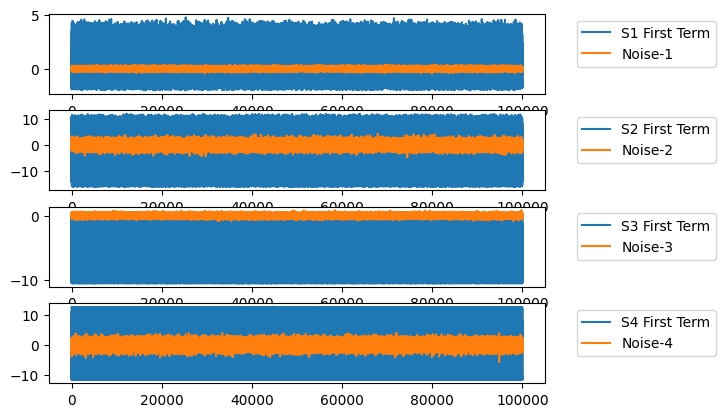

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(4, 1, 1)
plt.plot(source1_1st_term, label='S1 First Term')
plt.plot(source1_noise_term, label='Noise-1')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(source2_1st_term, label='S2 First Term')
plt.plot(noise2, label='Noise-2')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(source3_1st_term, label='S3 First Term')
plt.plot(noise3, label='Noise-3')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(source4_1st_term, label='S4 First Term')
plt.plot(noise4, label='Noise-4')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()

In [ ]:
!pip install cdt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.1/921.1 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=6fddca251a90e86ead112b409de0d6b4faa793d66709cb50fba77fbc1608717d
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29255 sha256=43884900f45bccb3c72446b916b33d8ff9293f837cdd49ebf1a91bff0a8a0a09
  Stored in directory: /root/.cache/pip/wheels/dd/67/40/683074a684607162bd0e34dcf7ccdfcab5861c3b2a83286f3a
Successfully built GPUtil skrebate


In [ ]:
import cdt

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


#Data Pre-processing

In [ ]:
import numpy as np
import pandas as pd

def data_preprocessing(data, max_lag=5):
  from sklearn.preprocessing import MinMaxScaler

  #convert to numpy array
  syn_data_np = data.to_numpy()

  #normalize the dataset
  scaler_X = MinMaxScaler(feature_range=(0, 1))
  syn_data_np_nor = scaler_X.fit_transform(syn_data_np)
  syn_data_np = syn_data_np_nor

  #transform into 2D data
  syn_data_np_T= syn_data_np.T
  syn_data_pro = np.zeros((syn_data_np.shape[0]-max_lag,syn_data_np.shape[1],(max_lag+1)))
  for i in range(0, (syn_data_np.shape[0]-max_lag)):
    syn_data_pro[i,:,:]= syn_data_np_T[:, i:i+(max_lag+1)]
  syn_data_2d = np.expand_dims(syn_data_pro, axis =-1)

  #make datafrom with normalized data
  syn_data_nor_df =pd.DataFrame(data = syn_data_np,
                  columns = data.columns)

  #transform normalized data into 1D shape with lagged and current time values
  size_1d = syn_data_np.shape[1]*(max_lag+1)
  print(size_1d)
  syn_data_1d = np.zeros((syn_data_np.shape[0]-max_lag,size_1d))
  for i in range(0, (syn_data_np.shape[0]-max_lag)):
    for j in range(0,(max_lag+1)):
      j_end = j * syn_data_np.shape[1]
      syn_data_1d[i,j_end:j_end+syn_data_np.shape[1]]= syn_data_np[i+j, :]

  #transform non-normalized data into 1D shape with lagged and current time values
  syn_data_np_2 = data.to_numpy()
  syn_data_1d_not_norm = np.zeros((syn_data_np_2.shape[0]-max_lag,size_1d))
  for i in range(0, (syn_data_np_2.shape[0]-max_lag)):
    for j in range(0,(max_lag+1)):
      j_end = j * syn_data_np_2.shape[1]
      syn_data_1d_not_norm[i,j_end:j_end+syn_data_np_2.shape[1]]= syn_data_np_2[i+j, :]


  return syn_data_np_nor, syn_data_2d, syn_data_nor_df, syn_data_1d,  syn_data_1d_not_norm

In [ ]:
syn_data_np, syn_data_2d, syn_data_nor_df, syn_data_1d,  syn_data_1d_not_norm = data_preprocessing(data, max_lag=5)

12


In [ ]:
syn_data_2d.shape

(99998, 4, 3, 1)

In [ ]:
syn_data_np_nor.shape

(100000, 4)

In [ ]:
syn_data_nor_df.shape

(100000, 4)

In [ ]:
syn_data_1d.shape

(99998, 12)

In [ ]:
syn_data_1d_not_norm.shape

(99998, 12)

In [ ]:
syn_data_np.shape, syn_data_2d.shape

((100000, 4), (99995, 4, 6, 1))

In [ ]:
data_y_syn = syn_data_np[5:,0:4]
data_y_syn.shape

(99995, 4)

# Model

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, AveragePooling2D, LSTM, Activation, ConvLSTM2D, TimeDistributed, Input, Reshape
from keras.layers import UpSampling1D, Conv2DTranspose, UpSampling2D, Conv1D, AveragePooling1D, LeakyReLU
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
import keras.backend as K
import tensorflow as tf
from keras.layers import concatenate
from keras.regularizers import l1, l2
from time import time

keras.utils.set_random_seed(1001)

In [ ]:
import tensorflow_probability as tfp

In [ ]:
class CausalConv2D(tf.keras.layers.Layer):
    def __init__(self, num_outputs, counter, *args, **kwargs):
        super(CausalConv2D, self).__init__()
        self.conv2d = tf.keras.layers.Conv2D(*args, **kwargs)
        self.num_outputs = num_outputs
        self.counter = counter

    def build(self, input_shape):
        self.W=self.add_weight(name='kernel',
                           shape=(input_shape[1], input_shape[2],input_shape[3], 1),
                           #initializer = keras.initializers.RandomUniform(minval=0.05, maxval=0.5),
                           #initializer ='uniform',
                           initializer = tf.keras.initializers.glorot_uniform(seed=8),
                           trainable=True)
        self.mask = np.ones(shape=self.W.shape)
        print(self.W)
        self.mask[self.counter,(input_shape[2]-1),...] = 0.0

    #def masked_convolution_op(self, filters, kernel, mask):
    #    return self._convolution_op(filters, tf.math.multiply(kernel, tf.reshape(mask, mask.shape + [1,1] )))

    def get_weights(self):
        return super().get_weights()

    def call(self, inputs):
        self.W.assign(tf.math.multiply(self.W, self.mask))
        #self.conv2d._convolution_op = functools.partial(self.masked_convolution_op, mask=mask)
        #return self.conv2d.call(x)
        return self.conv2d.convolution_op(inputs, self.W)

In [ ]:
# 2D
def get_model_2d(input_dims):
    input_batch = Input(shape = input_dims)

    conv_model = Sequential()
    conv_model = Conv2D(filters=4, kernel_size=1, strides=(1,1), padding='valid', activation="linear", name='conv1')(input_batch)
    #conv_model = AveragePooling2D(pool_size=(1,1), strides=None, padding='valid', name='pool1')(conv_model) activation=LeakyReLU(0.05)
    conv_model = tf.math.reduce_mean(conv_model, axis=-1)
    conv_model = Reshape((4, 6, 1))(conv_model)
    #conv_model = Flatten()(conv_model )
    pooled_outputs = []
    for i in range(0, 4):
      #layer = CausalConv2D(num_outputs=1, counter=i, name="parr"+str(i))(conv_model) # , kernel_regularizer = l1(0.2)
      layer = CausalConv2D(filters=1, kernel_size=(4,6), num_outputs=1, counter=i, padding='valid', activation="tanh",)(conv_model)
      #den1 = layer(tf.ones([481, 30]))
      #conv = Conv2D(1, kernel_size=filter_sizes[i], padding='valid', activation='relu')(conv_model)
      pooled_outputs.append(layer)
    output = concatenate(pooled_outputs)
    output = Flatten()(output)

    model = Model(inputs=input_batch, outputs=output, name='cpred')

    return model

In [ ]:
# with gradient tape

class CausalNNModel(object):
    def __init__(self,
                 dims,
                 alpha=0.0,
                 rho = 1.0,
                 rho_max = 10e20,
                 h_tol = 1e-8,
                 init='glorot_uniform'):

        super(CausalNNModel, self).__init__()

        self.dims = dims
        self.n_stacks = len(self.dims) - 1
        self.alpha = alpha
        self.rho = rho
        self.h_p = np.Inf
        self.rho_max = rho_max
        self.h_tol = h_tol
        self.model_2d = get_model_2d(self.dims)
        print("====Model created=====")

        self.model = Model(inputs=self.model_2d.input, outputs=self.model_2d.output)


    def extract_features(self, x):
        return self.model_cnn.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)[1]
        return q.argmax(1)

    def custom_loss_function(self, y_true, y_pred):
      mse = keras.losses.mean_squared_error(y_true, y_pred)
      h_val = self.causal_loss_h()
      h_loss = 0.5 * self.rho * h_val * h_val + self.alpha * h_val
      lambda1 = 0.1
      adj_mat = self.get_mat()
      sparse_loss = lambda1 * tf.math.reduce_sum(tf.abs(adj_mat))
      #neg_weight = np.sum(adj_mat, where=adj_mat<0)
      #neg_loss = 0.5 * tf.abs(neg_weight)
      print('MSE Loss is: {}, h Loss is: {}, L1 loss: {}, Total Loss is: {}'.format(tf.reduce_mean(mse), h_loss, sparse_loss, tf.reduce_mean(mse)+h_loss))
      return mse + h_loss + sparse_loss #+ neg_loss

    def causal_loss_h(self):
      mat = self.get_mat()
      h_val = self.h_acy_1(mat[:, 20:])
      return h_val

    def get_mat(self):
      w1_2d_s = self.model.get_layer(index=-6).get_weights()
      w2_2d_s = self.model.get_layer(index=-5).get_weights()
      w3_2d_s = self.model.get_layer(index=-4).get_weights()
      w4_2d_s = self.model.get_layer(index=-3).get_weights()
      arr1_2d_s = np.expand_dims(np.squeeze(np.array(w1_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      arr2_2d_s = np.expand_dims(np.squeeze(np.array(w2_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      arr3_2d_s = np.expand_dims(np.squeeze(np.array(w3_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      arr4_2d_s = np.expand_dims(np.squeeze(np.array(w4_2d_s), axis=(0,3,4)).flatten('F'), axis=0)
      mat_2d_s = np.concatenate((arr1_2d_s, arr2_2d_s, arr3_2d_s, arr4_2d_s))
      #print(mat_2d_s)
      return mat_2d_s

    def h_acy_1(self, A):
      n_var = A.shape[0]
      h = tf.linalg.trace(tf.linalg.expm(A * A)) - n_var
      return h


    def h_acy(self, A):
      '''Calculate the constraint of A ensure that it's a DAG'''
      #(Yu et al. 2019 DAG-GNN)
      # h(w) = tr[(I + kA*A)^n_variables] - n_variables
      n_var = A.shape[0]
      M = tf.eye(n_var, num_columns = n_var) + A/n_var
      E = M
      for _ in range(n_var - 2):
        E = tf.linalg.matmul(E, M)
      h = tf.math.reduce_sum(tf.transpose(E) * M) - n_var
      return h

    def compile(self, optimizer='adam'):
        self.model.compile(optimizer=optimizer, loss= self.custom_loss_function) # ['mse', self.causal_loss()])

    def fit(self, x, y=None, maxiter=100, batch_size=512, save_dir='./results/temp'):
        t1 = time()


        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/causalnn_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter','loss'])
        logwriter.writeheader()
        train_loader = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)
        optimizer = tf.keras.optimizers.Adam(1e-2)
        w1_2d_s = self.model.get_layer(index=-6).get_weights()
        arr1_2d_s = np.expand_dims(np.squeeze(np.array(w1_2d_s), axis=(0,3,4)).flatten('F'), axis=0)


        for epoch in range(int(maxiter)):
          print('Epoch: {}', epoch)
          h_n = None
          for (x, y) in train_loader:
            #eval loss and compute gradients
            with tf.GradientTape() as tape:
              tape.watch(self.model.trainable_variables)
              #passing through neural network
              output = self.model(x)
              #calculate loss
              loss = self.custom_loss_function(y, output)
              gradients = tape.gradient(loss, self.model.trainable_variables)
              optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
              h_n = self.causal_loss_h()
              #print('New h_val is :', h_n)
              #if h_n > 0.25 * self.h_p:
              #  self.rho = self.rho*10
              #else:
              #  break

          if h_n > 0.25 * self.h_p:
                self.rho = self.rho*1.1
          self.h_p = h_n
          print('New h_val is :', h_n)
          self.alpha += self.rho * self.h_p

          if self.h_p <= self.h_tol or self.rho >= self.rho_max:
            print('Before the loop end # h_val is: {}, rho is: {}'.format(self.h_p, self.rho))
            break

        #for ite in range(int(maxiter)):
        #  print('Epoch: {}', ite)
        #  self.model.fit(x, y, epochs=1, batch_size=batch_size, verbose=True)

        # save the trained model
        logfile.close()
        file_name  = "/CausalNN_model_final_" + str(round(time()))+ ".h5"
        print('saving model to:', save_dir + file_name)
        self.model.save_weights(save_dir + file_name)

        w1_2d_s_1 = self.model.get_layer(index=-6).get_weights()
        arr1_2d_s_1 = np.expand_dims(np.squeeze(np.array(w1_2d_s_1), axis=(0,3,4)).flatten('F'), axis=0)

        y_pred = self.model.predict(x)
        adj_mat = self.get_mat()

        print('The conv layer 1 weights before training :', arr1_2d_s)
        print('The conv layer 1 weights after training :', arr1_2d_s_1)

        return y_pred, adj_mat

#Model creation and training:

In [ ]:
keras.utils.set_random_seed(1001)

cnnmodel = CausalNNModel(dims=syn_data_2d.shape[1:])

<tf.Variable 'causal_conv2d/kernel:0' shape=(4, 6, 1, 1) dtype=float32, numpy=
array([[[[ 0.01729116]],

        [[ 0.05369946]],

        [[-0.11558445]],

        [[-0.1930318 ]],

        [[-0.22727013]],

        [[-0.10506889]]],


       [[[-0.03241783]],

        [[ 0.34967968]],

        [[-0.22822307]],

        [[ 0.18624505]],

        [[-0.03919902]],

        [[-0.03960952]]],


       [[[ 0.20739552]],

        [[-0.14644605]],

        [[ 0.21469983]],

        [[-0.17902574]],

        [[ 0.06509387]],

        [[ 0.17076865]]],


       [[[ 0.21393666]],

        [[-0.3412853 ]],

        [[ 0.0880048 ]],

        [[-0.3153036 ]],

        [[-0.07369781]],

        [[ 0.15640828]]]], dtype=float32)>
<tf.Variable 'causal_conv2d_1/kernel:0' shape=(4, 6, 1, 1) dtype=float32, numpy=
array([[[[ 0.01729116]],

        [[ 0.05369946]],

        [[-0.11558445]],

        [[-0.1930318 ]],

        [[-0.22727013]],

        [[-0.10506889]]],


       [[[-0.03241783]],

        [

In [ ]:
cnnmodel.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4, 6, 1)]            0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 4, 6, 4)              8         ['input_1[0][0]']             
                                                                                                  
 tf.math.reduce_mean (TFOpL  (None, 4, 6)                 0         ['conv1[0][0]']               
 ambda)                                                                                           
                                                                                                  
 reshape (Reshape)           (None, 4, 6, 1)              0         ['tf.math.reduce_mean[0][0

In [ ]:
cnnmodel.compile()

In [ ]:
y_pred, mat = cnnmodel.fit(x=syn_data_2d, y=data_y_syn, maxiter=20, batch_size=2048, save_dir='/content/')

Epoch: {} 0
MSE Loss is: 0.3329330384731293, h Loss is: 1.003495640361507e-06, L1 loss: 1.4565690755844116, Total Loss is: 0.33293405175209045
MSE Loss is: 0.32225242257118225, h Loss is: 1.1561634210011107e-06, L1 loss: 1.4485690593719482, Total Loss is: 0.32225358486175537
MSE Loss is: 0.30539023876190186, h Loss is: 1.372049609926762e-06, L1 loss: 1.4406925439834595, Total Loss is: 0.3053916096687317
MSE Loss is: 0.3028430938720703, h Loss is: 1.6720179019102943e-06, L1 loss: 1.4330716133117676, Total Loss is: 0.302844762802124
MSE Loss is: 0.2951931655406952, h Loss is: 2.0884040168311913e-06, L1 loss: 1.4307571649551392, Total Loss is: 0.29519525170326233
MSE Loss is: 0.2803803086280823, h Loss is: 2.670891262823716e-06, L1 loss: 1.4430142641067505, Total Loss is: 0.28038299083709717
MSE Loss is: 0.26060664653778076, h Loss is: 3.500576895021368e-06, L1 loss: 1.4561830759048462, Total Loss is: 0.2606101334095001
MSE Loss is: 0.237020343542099, h Loss is: 4.6974473661975935e-06, L1

In [ ]:
y_pred_nn, mat_nn = cnnmodel.fit(x=syn_data_2d_nn, y=data_y_syn_nn, maxiter=20, batch_size=2048, save_dir='/content/')

Epoch: {} 0
MSE Loss is: 33.54899597167969, h Loss is: 1.003495640361507e-06, L1 loss: 1.4565690755844116, Total Loss is: 33.54899597167969
MSE Loss is: 32.97697830200195, h Loss is: 1.230557700182544e-06, L1 loss: 1.4465690851211548, Total Loss is: 32.97697830200195
MSE Loss is: 32.64115905761719, h Loss is: 1.5379196156573016e-06, L1 loss: 1.4370572566986084, Total Loss is: 32.64115905761719
MSE Loss is: 30.624813079833984, h Loss is: 1.9636372599052265e-06, L1 loss: 1.4292304515838623, Total Loss is: 30.624814987182617
MSE Loss is: 30.067358016967773, h Loss is: 2.5542703951941803e-06, L1 loss: 1.42755126953125, Total Loss is: 30.067359924316406
MSE Loss is: 29.546630859375, h Loss is: 3.3767832974263e-06, L1 loss: 1.4413032531738281, Total Loss is: 29.546634674072266
MSE Loss is: 29.134113311767578, h Loss is: 4.523697498370893e-06, L1 loss: 1.4561477899551392, Total Loss is: 29.134117126464844
MSE Loss is: 28.35997200012207, h Loss is: 6.114937150414335e-06, L1 loss: 1.47253894805

In [ ]:
y_pred[0:5], data_y_syn[0:5]

(array([[0.28146005, 0.49190438, 0.1881849 , 0.17641288],
        [0.2992469 , 0.48059452, 0.22816728, 0.19841833],
        [0.33408394, 0.42284498, 0.33214664, 0.19857386],
        [0.29867512, 0.48222014, 0.29584503, 0.12229615],
        [0.33640367, 0.61653215, 0.2618387 , 0.19631158]], dtype=float32),
 array([[0.589811  , 0.55491996, 0.75778573, 0.5528252 ],
        [0.61878201, 0.52792297, 0.82147084, 0.53097383],
        [0.56813402, 0.52503256, 0.86755772, 0.5733878 ],
        [0.61048959, 0.57615099, 0.77059246, 0.55889173],
        [0.5042508 , 0.56395476, 0.84200102, 0.59009443]]))

In [ ]:
mat = np.genfromtxt('/content/proposed-full-adj-mat-V3.csv', delimiter=',')

In [ ]:
mat_df_2d_s = pd.DataFrame(mat)

In [ ]:
mat_f_df = pd.DataFrame(mat).T

In [ ]:
mat_df_2d_s.T

,0,1,2,3
0,0.060424,-0.086885,0.158718,-0.023992
1,-0.071343,0.219383,-0.102552,-0.049103
2,0.197360,0.230671,0.013068,-0.011465
3,-0.518587,0.195263,0.023268,-0.004621
4,0.416361,0.019698,0.006211,0.048413
5,-0.010432,0.209990,-0.004963,-0.034856
6,-0.019452,0.071430,0.007873,-0.011133
7,0.013019,-0.285973,-0.074198,-0.009662
8,0.215037,-0.135168,0.307494,-0.130542
9,-0.031971,0.131829,0.021005,-0.069707


In [ ]:
mat_f_df.iloc[20:,:]

,0,1,2,3
20,0.000000,-0.173380,0.080703,-0.061715
21,-0.095194,0.000000,0.037806,-0.136843
22,0.069021,0.172888,0.000000,0.835213
23,-0.108998,-0.878886,2.633786,0.000000


#Full Causal Graph

In [ ]:
import networkx as nx
G_2d_s = nx.DiGraph()

nodes_2d_s = ["S1(t-5)", "S2(t-5)", "S3(t-5)",  "S4(t-5)",
         "S1(t-4)", "S2(t-4)", "S3(t-4)",  "S4(t-4)",
         "S1(t-3)", "S2(t-3)", "S3(t-3)",  "S4(t-3)",
         "S1(t-2)", "S2(t-2)", "S3(t-2)",  "S4(t-2)",
         "S1(t-1)", "S2(t-1)", "S3(t-1)",  "S4(t-1)",
         "S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
nodes_r_2d_s=["S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
pred_graph_f = np.zeros((4,24))

In [ ]:
for i in range (0, 24):
  G_2d_s.add_node(nodes_2d_s[i],pos=(int(i/4)+1,(i%4)+1))

In [ ]:
for i in range(0, 24):
  for j in range (0, 4):
    if abs(matrix_2d_2d_s[j,i]) > 0.3:
      print(i,j)
      G_2d_s.add_edge(nodes_2d_s[i], nodes_r_2d_s[j], weight=i)


0 0
3 2
4 0
8 0
12 0
13 1
16 0
16 1
17 1
18 3
20 1
23 2


In [ ]:
pos_2d_s=nx.get_node_attributes(G_2d_s,'pos')
#pos_2d_s

In [ ]:
weights_2d_s = nx.get_edge_attributes(G_2d_s,'weight').values()

In [ ]:
import matplotlib.pyplot as plt #data1

plt.figure(figsize=(8, 6))
nx.draw(G_2d_s, pos_2d_s, cmap = plt.get_cmap('jet'), edge_cmap= plt.cm.tab20, edge_color=weights_2d_s, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.show()

In [ ]:
cdt.metrics.SHD(true_full_graph, pred_graph_f)

8.0

In [ ]:
true_values = true_full_graph
predictions = pred_graph_f

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.9166666666666666, Precision: 0.5454545454545454, Recall: 0.6666666666666666, FDR: 0.45454545454545453, F1 Score: 0.6


#Summary Causal Graph

In [ ]:
import networkx as nx
G_2d_s1 = nx.DiGraph()

nodes_2d_s1 = ["S1", "S2", "S3",  "S4"]
nodes_r_2d_s1= ["S1", "S2", "S3",  "S4"]
edges_2d_s1 = []
pred_graph_s1 = np.zeros((4,4))

In [ ]:
for i in range (0, 4):
  G_2d_s1.add_node(nodes_2d_s1[i],pos=(int(i/2)+1,(i%2)+1))

In [ ]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_2d_s[j,i] > 0.3:
      print(i,j)
      col = np.round(matrix_2d_2d_s[j,i], 2)
      G_2d_s1.add_edge(nodes_2d_s1[i%4], nodes_r_2d_s1[j], weight=1)
      pred_graph_s1[i%4, j]=1


In [ ]:
pos_2d_s1=nx.get_node_attributes(G_2d_s1,'pos')
pos_2d_s1

{'S1': (1, 1), 'S2': (1, 2), 'S3': (2, 1), 'S4': (2, 2)}

In [ ]:
weights_2d_s1 = nx.get_edge_attributes(G_2d_s1,'weight').values()

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


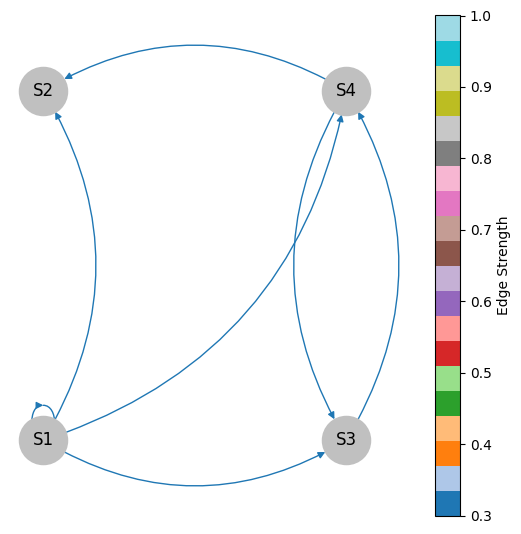

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(5, 5))
nx.draw(G_2d_s1, pos_2d_s1,  edge_cmap= plt.cm.tab20,  #cmap = plt.get_cmap('jet'),
        font_size=12, node_size=1200, node_color='#c0c0c0', #[30,30,30,30,30],
        edge_color=weights_2d_s1, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0.3, 1), cmap=plt.cm.tab20),
              orientation='vertical', label='Edge Strength')
plt.show()

In [ ]:
pred_graph_s1

In [ ]:
true_graph

In [ ]:
cdt.metrics.SHD(true_graph, pred_graph_s1)

3.0

In [ ]:
true_values = true_graph
predictions = pred_graph_s1

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.8125, Precision: 0.7142857142857143, Recall: 0.8333333333333334, FDR: 0.2857142857142857, F1 Score: 0.7692307692307692


# Non-stationarity test

####ADF Test for Stationarity

Null hypothesis: The time series has a unit root and is not stationary.

If failed to be rejected, it suggests the time series is not stationarity.

If p-values is higher than 0.05 alpha level, we cannot reject the null hypothesis. So the time series is not stationary.

In [ ]:
#ADF Test for non-stationarity
def adf_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    stationary = []
    for c in data_df.columns:
        adf_res = adfuller(data_df[c].dropna(), autolag='AIC')
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
        if adf_res[1] > 0.05:
          stationary.append('No')
        else:
          stationary.append('Yes')
    adf_res_df = pd.DataFrame({'Test statistic': test_stat,
                               'p-value': p_val,
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct,
                               'Stationary': stationary},
                             index=data_df.columns).T
    adf_res_df = adf_res_df.round(4)
    return adf_res_df

In [ ]:
adf_test(data)

#### KPSS Test for Stationary

Null hypothesis: The time series is stationary.

If the p-value is less than 0.05 alpha level, we can reject the null hypothesis and derive that the time series is not stationary.

In [ ]:
def kpss_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    stationary = []
    for c in data_df.columns:
        kpss_res = kpss(data_df[c].dropna())#, regression='ct')
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['2.5%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
        if kpss_res[1] > 0.05:
          stationary.append('Yes')
        else:
          stationary.append('No')
    kpss_res_df = pd.DataFrame({'Test statistic': test_stat,
                               'p-value': p_val,
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct,
                               'Stationary': stationary},
                             index=data_df.columns).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

In [ ]:
kpss_test(data)